# Tools and import

In [1]:
import json
from statistics import median, mean
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
from sklearn.cluster import KMeans

In [2]:
def get_power(hostname, start, end, cache_dir='cache', copydest=None):
    host, site, _, _ = hostname.split('.')
    source = '%s/%s_%s_%s_%s' %(cache_dir, host, site, start, end)

    with open(source, 'r') as file:
        data = file.read()

    if not copydest is None:
        shutil.copy(source, copydest)

    raw = json.loads(data)['items'][0]
    timestamps = raw['timestamps']
    values = raw['values']

    return timestamps, values

# Nas Parallel benchmarks at different frequencies

* uses the file **2020_dvfs_npb**
* uses the directory **dvfs_npb**
* creates the file **benchmarks_u.pdf**
* is used in the figure **fig:dvfs_npb**

In [6]:
def get_energy_data(line, cache_dir='cache'):
    (hostname, bench, benchclass, nbcore, speed, startTime, endTime, fmax, fmin, pctmax, pctmin) = line.split()
    (_, values) = get_power(hostname, startTime, endTime, cache_dir=cache_dir)

    host, site, _, _ = hostname.split('.')
    cluster, _ = host.split('-')
    
    _, idle = get_power(hostname, int(startTime)-5, int(startTime)-1, cache_dir=cache_dir)
    
    return (host, cluster, site, bench, benchclass, int(nbcore), float(speed), median(values), median(idle), int(fmax), int(fmin), int(pctmax), int(pctmin))

In [7]:
def make_graph_simplified(dvfs_freq, bench, metric, ax, max_power, xmesh, color_freq='b'):
    ratios=dvfs_freq.groupby('ratio')
    benchmark_data_with_std = pd.concat([ratios.mean()[metric],ratios.std()[metric]], axis=1, keys=[metric,"std"]).reset_index()
    benchmark_data_with_std.plot(kind = "scatter", color=color_freq, x='ratio', y=metric, yerr='std', ax=ax)

    ax.set_title("Benchmark "+bench, loc='left')
    ax.set_ylabel(metric)

    fit = np.poly1d(np.polyfit(dvfs_freq['ratio'], dvfs_freq[metric], max_power))
    ax.plot(xmesh, fit(xmesh), '-b', color=color_freq)

    if metric=='power':
        make_graph_simplified(dvfs_freq, bench, 'idlePower', ax, max_power, xmesh, 'g')
        ax.legend(labels=["Benchmark", 'Idle'])
        ax.set_ylabel('power')
        ax.set_ylim(ymin = dvfs_freq['idlePower'].min()*.9)
    ax.set_xlabel('ratio')

In [8]:
with open('2020_dvfs_npb') as file:
    raw = file.readlines()
    
res = [get_energy_data(line, cache_dir='dvfs_npb') for line in raw]
dataset = pd.DataFrame(res, columns=['host', 'cluster', 'site', 'bench', 'benchClass', 'nbCore', 'time', 'power', 'idlePower', 'fMax', 'fMin', 'pctMax', 'pctMin'])

dataset['energy'] = dataset.apply(lambda row: row.time * row.power, axis=1)

tmpfreqmax=dataset.groupby('cluster').max()
dataset.loc[:, ('ratio')] = dataset.apply(lambda row:  row.fMax / tmpfreqmax.fMax[row.cluster]     , axis=1)

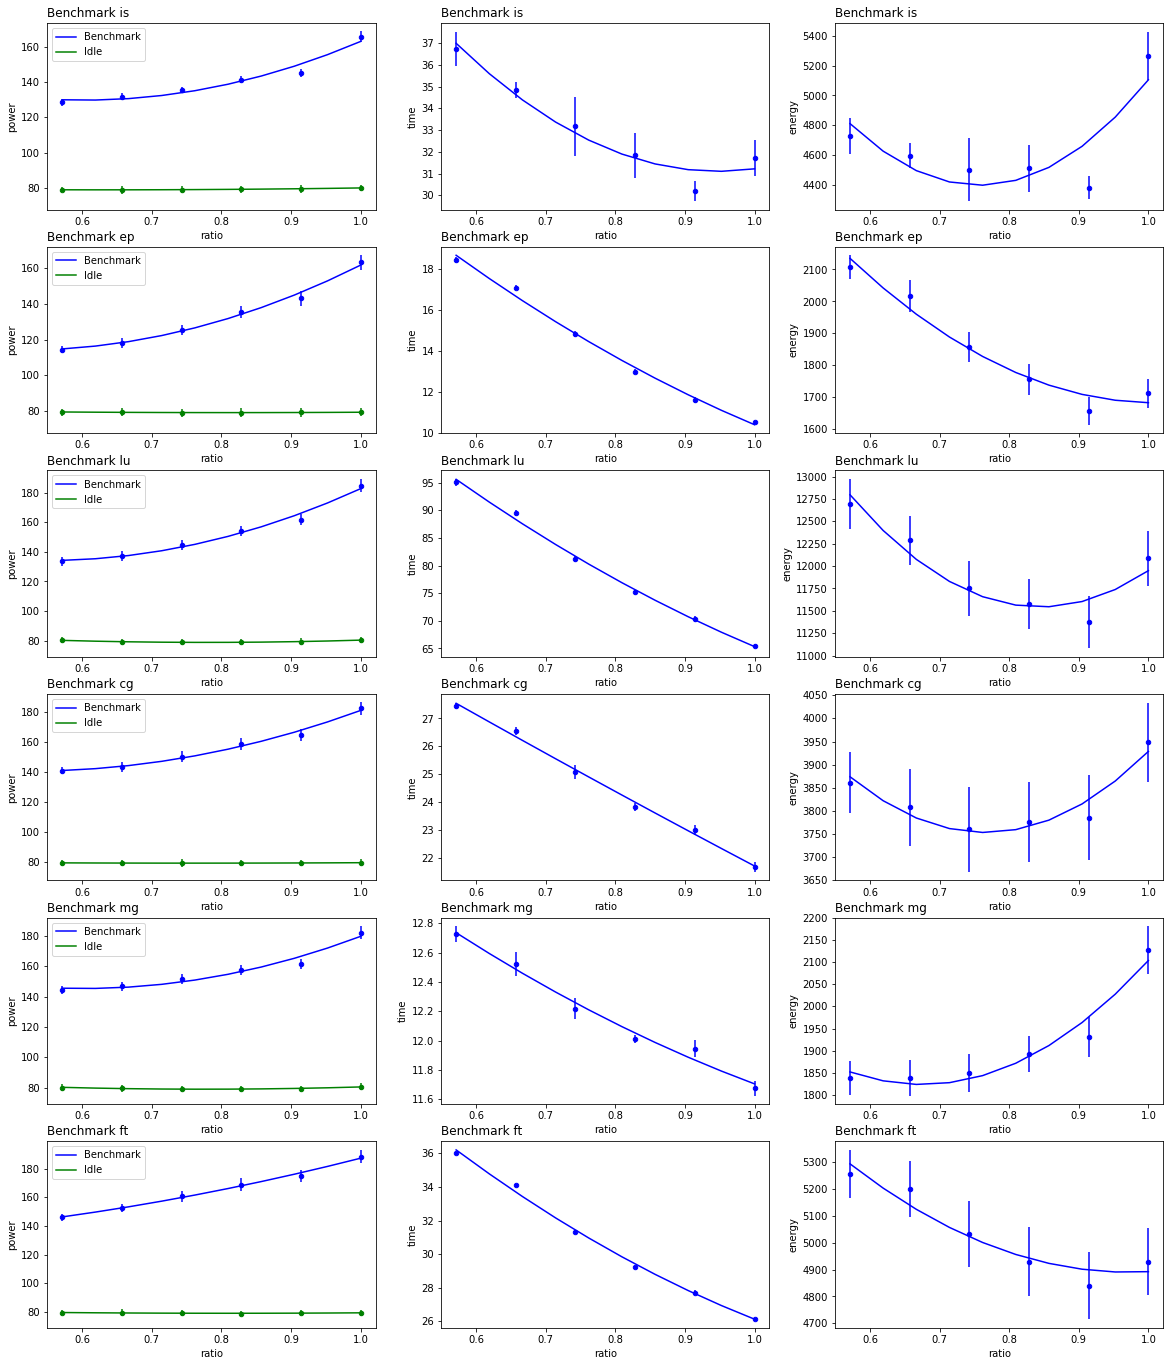

In [9]:
fit_max_power = 2

benches = set(dataset.bench)
fig = plt.figure(figsize=(20,4*len(benches)))
axes=[fig.add_subplot(len(benches),3, i) for i in range(1,len(benches)*3+1)]

for idx, bench in enumerate(benches):
    dvfs_freq = dataset[ dataset['bench']==bench ]
    xmesh = np.linspace(min(dvfs_freq['ratio']), max(dvfs_freq['ratio']), 10)

    make_graph_simplified(dvfs_freq, bench, 'power', axes[3*idx], fit_max_power, xmesh)
    make_graph_simplified(dvfs_freq, bench, 'time', axes[3*idx+1], fit_max_power, xmesh)
    make_graph_simplified(dvfs_freq, bench, 'energy', axes[3*idx+2], fit_max_power, xmesh)

fig.savefig('benchmarks_u.pdf',format='pdf', pad_inches=0, bbox_inches='tight')

# Constants related the servers hardware

* uses the file **2020_burn** and **2020_ratios**
* uses the directory **clusters**

In [10]:
def power_to_energy(timestamps, power):
    'Approximates missing timestamps'
    mu = median([timestamps[i+1]-timestamps[i] for i in range(len(timestamps)-1)])

    energy = power[0] * mu/2

    for tidx in range(len(timestamps)-1):
        delta = timestamps[tidx+1]-timestamps[tidx]
        energy += (power[tidx]+power[tidx+1])*(delta)/2

    energy += power[-1]*mu/2
    return energy

In [11]:
def get_energy_constants(string, debug=False, show_reboot=False):
    (hostname, startIdle, endIdle, startStress, endStress, startOff, startOn, endOn) = string.split()
            
    if debug:
        print(hostname)
    (timestamps, values) = get_power(hostname, startIdle, endIdle, cache_dir='clusters')
    pIdle = mean(values)
    if debug:
        print('Idle (W)', pIdle, '(stdev', stdev(values),')')
        print(values)
    (timestamps, values) = get_power(hostname, startStress, endStress, cache_dir='clusters')
    pMax = mean(values)
    if debug:
        print('Stressed (W)', pMax, '(stdev', stdev(values),')')
        print(values)
    (timestamps, values) = get_power(hostname, startOn, endOn, cache_dir='clusters')
    eOn = power_to_energy(timestamps, values)
    tOn = (timestamps[-1]-timestamps[0])*(len(timestamps)+1)/len(timestamps)
    if debug:
        print('Power On',eOn, 'J in',tOn,'s')
        print(values)

    (timestamps, values) = get_power(hostname, startOff, startOn, cache_dir='clusters')
    if debug:
        print('Power Off detection')
        print(values)
    df=pd.DataFrame(values)
    if debug:
        print(hostname, startOff, startOn, debug)
    kmeans = KMeans(n_clusters=2).fit(df)
    centroids = kmeans.cluster_centers_
    pos = list(kmeans.labels_).index(kmeans.labels_[-1])
    
    if debug:
        ax = df.plot(title=str(Counter(kmeans.labels_))+' '+str(kmeans.score(df)))
        for val in centroids:
            ax.axhline(y=val[0], color='r', linestyle='-')
        ax.axvline(x=pos, color='g', linestyle='-')
    eOff=power_to_energy(timestamps[:pos], values[:pos])
    tOff=(timestamps[pos-1]-timestamps[0])*(len(timestamps)+1)/len(timestamps)
    
    if show_reboot == hostname:
        print('"%s", %s, %s  <->   %s, %s' % (hostname, startOff, endOn, pos, int(startOn)-int(startOff)))
    
    if debug:
        print('Power Off', eOff, 'J in', tOff,'s')
    
    pOff = median(values[pos:])
    
    if debug:
        print('Powered Off (W)', pOff)
    host, site, _, _ = hostname.split('.')
    return(host, site, pOff, pIdle, pMax, tOn, eOn, tOff, eOff)

In [12]:
res = []
# uses CPUBURN to zoom on time needed to start/reboot/...
with open('2020_ratios') as file:
    raw = file.readlines()
for line in raw:
    res.append(get_energy_constants(line, show_reboot="grisou-17.nancy.grid5000.fr"))

df_ratio = pd.DataFrame(res, columns=['host', 'site', 'pOff', 'pIdle', 'pMax', 'tOn', 'eOn', 'tOff', 'eOff'])
df_ratio['cluster'] = df_ratio.apply(lambda row: row.host.split('-')[0], axis=1)

df_ratio_cluster=df_ratio.groupby('cluster').mean()


"grisou-17.nancy.grid5000.fr", 1581074737, 1581074996  <->   15, 120
"grisou-17.nancy.grid5000.fr", 1581075256, 1581075518  <->   17, 120
"grisou-17.nancy.grid5000.fr", 1581075778, 1581076042  <->   16, 120
"grisou-17.nancy.grid5000.fr", 1581076302, 1581076564  <->   17, 121
"grisou-17.nancy.grid5000.fr", 1581076824, 1581077087  <->   15, 120


In [13]:
res = []
# uses LU as it is one of the most power hungry benchmark
with open('2020_burn') as file:
    raw = file.readlines()
for line in raw:
    try:
        hostname, bench, process, nbprocs, size, stime, etime = line.split()
        _, vals = get_power(hostname, stime, etime, cache_dir='clusters')
        host, site, _, _ = hostname.split('.')
        cluster, _ = host.split('-')
        res.append([host, cluster, site, bench, process, nbprocs, median(vals), len(vals), size])
    except:
        print('problem with', line.strip())
        pass

df_burn = pd.DataFrame(res, columns=['host', 'cluster', 'site', 'bench', 'process','nbprocs', 'pMax', 'time', 'class'])

problem with gros-90.nancy.grid5000.fr lu 9 36 C 1581632269 1581632517


In [14]:
df_ratio_cluster['pMax2'] = df_ratio_cluster.apply(lambda row: max(df_burn[df_burn['cluster']==row.name].mean().pMax, row.pMax), axis=1)

# For Gros cluster the kwapi interface did not work as the cluster was recent. The values are extracted 'by hand' from  cache/gros*.rrd
df_ratio_cluster.loc['gros'] = [20,62,180,164,18126,6,459,213] # data from cache/gros*.rrd

In [15]:
import time

df_ratio_cluster['ratio'] = df_ratio_cluster.apply(lambda row: row.pIdle/row.pMax2 , axis=1)

# Data obtained from https://www.grid5000.fr/w/Hardware
CPUyear = {'troll':2019, 'yeti':2017, 'sagittaire':2004, 'parapluie':2010, 'taurus':2012, 'parasilo':2014, 'paravance':2014, 
        'nova':2016, 'parapide':2009, 'grisou':2014, 'grimoire':2014, 'graoully':2014, 'gros':2019}
df_ratio_cluster['CPUyear'] = df_ratio_cluster.apply(lambda row: CPUyear[row.name], axis=1)

CPUyear = {'troll':'2019-04-01', 'yeti':'2017-07-01', 'sagittaire':'2004-05-01', 'parapluie':'2010-03-29', 'taurus':'2012-01-01', 'parasilo':'2014-07-01',
           'paravance':'2014-07-01', 'nova':'2016-01-01', 'parapide':'2009-01-01', 'grisou':'2014-07-01', 'grimoire':'2014-07-01',
           'graoully':'2014-07-01', 'gros':'2019-04-01'}
df_ratio_cluster['CPUyear'] = df_ratio_cluster.apply(lambda row: np.datetime64(CPUyear[row.name]), axis=1)

ServerYear = {'troll':'2019-12-23', 'yeti':'2018-01-16', 'sagittaire':'2006-07-01', 'parapluie':'2010-11-02', 'taurus':'2012-09-14', 'parasilo':'2015-01-13',
             'paravance':'2015-01-13', 'nova':'2016-12-01', 'parapide':'2010-01-25', 'grisou':'2016-01-04', 'grimoire':'2016-01-22', 'graoully':'2016-01-04',
             'gros':'2019-09-04'}
df_ratio_cluster['ServerYear'] = df_ratio_cluster.apply(lambda row: np.datetime64(ServerYear[row.name]), axis=1)

df_ratio_cluster['threshold'] = df_ratio_cluster.apply(lambda row: (row.eOn+row.eOff - (row.tOn+row.tOff)*row.pOff)/(row.pIdle-row.pOff), axis=1)

df_ratio_cluster

,pOff,pIdle,pMax,tOn,eOn,tOff,eOff,pMax2,ratio,CPUyear,ServerYear,threshold
cluster,,,,,,,,,,,,
graoully,0.000000,99.256591,226.653171,154.287062,24050.398884,13.271682,1525.839384,291.000000,0.341088,2014-07-01,2016-01-04,257.677984
grimoire,3.566667,121.475646,246.587059,135.457218,23744.109822,13.314758,1853.353487,304.400000,0.399066,2014-07-01,2016-01-22,212.594862
grisou,0.000000,88.893528,219.515104,144.918485,21314.808295,13.763222,1413.467478,285.400000,0.311470,2014-07-01,2016-01-04,255.679757
nova,9.423529,80.253469,170.348548,123.227179,14908.164706,14.471321,1307.417647,190.560000,0.421145,2016-01-01,2016-12-01,210.616819
parapide,23.833333,168.250000,272.768056,104.748310,15102.251439,29.603429,6242.825031,272.768056,0.616824,2009-01-01,2010-01-25,125.629729
parapluie,0.000000,166.343710,259.166667,133.108758,20330.194350,36.162186,7512.057840,259.166667,0.641841,2010-03-29,2010-11-02,167.377848
parasilo,0.000000,100.879699,240.531816,141.737518,23264.898885,15.136580,1727.461138,304.600000,0.331187,2014-07-01,2015-01-13,247.744197
paravance,0.000000,81.083702,214.907516,109.811477,15005.005698,15.137016,1436.686089,277.200000,0.292510,2014-07-01,2015-01-13,202.774311
sagittaire,12.900000,199.341322,251.241795,149.138074,29694.664286,15.555925,3314.714286,251.241795,0.793424,2004-05-01,2006-07-01,165.654403


## Plots and data

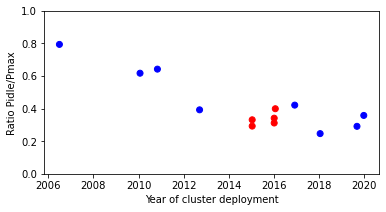

In [16]:
plt.figure(figsize=(6,3))
plt.xlabel("Year of cluster deployment")
plt.ylabel("Ratio Pidle/Pmax")
plt.ylim(ymin=0)

plt.scatter(df_ratio_cluster.ServerYear, df_ratio_cluster.ratio,
            color=['red' if str(year)[:10]=='2014-07-01' else 'blue' for year in df_ratio_cluster.CPUyear])

plt.savefig('ratio_serv.pdf',pad_inches=0, bbox_inches='tight')

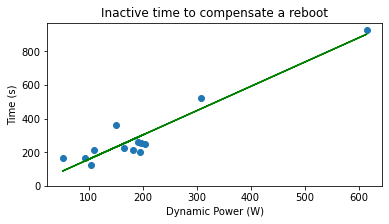

In [17]:
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(6,3))
plt.xlabel("Dynamic Power (W)")
plt.ylabel("Time (s)")
plt.title("Inactive time to compensate a reboot")

X = (df_ratio_cluster.pMax2-df_ratio_cluster.pIdle).values.reshape(-1, 1)
Y = (df_ratio_cluster.threshold).values.reshape(-1, 1)
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

plt.scatter(df_ratio_cluster.pMax2-df_ratio_cluster.pIdle, df_ratio_cluster.threshold)
plt.plot(X, Y_pred, color='green')
plt.ylim(ymin=0)

plt.savefig('boot.pdf',pad_inches=0, bbox_inches='tight')

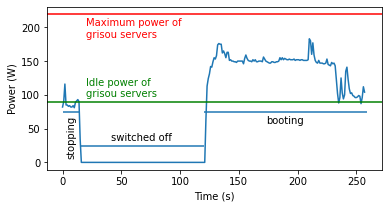

In [18]:
grisou_17_power_profile=get_power("grisou-17.nancy.grid5000.fr", 1581074737, 1581074996, cache_dir='clusters')[1]

grisou_pidle = df_ratio_cluster.loc['grisou'].pIdle
grisou_pmax = df_ratio_cluster.loc['grisou'].pMax

plt.figure(figsize=(6,3))
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")

plt.plot(grisou_17_power_profile, label='Server power')
plt.axhline(y=grisou_pidle, color='green')
plt.text(x=15+5, y=89+5, s='Idle power of\ngrisou servers', fontdict={'ha': 'left', 'va':'bottom'}, color='green')

plt.axhline(y=grisou_pmax, color='red')
plt.text(x=15+5, y=219.5-5, s='Maximum power of\ngrisou servers', fontdict={'ha': 'left', 'va':'top'}, color='red')

plt.hlines(y=25, xmin=15, xmax=120)
plt.text(x = (120-15)/2+15, y=25+5, s='switched off', fontdict={'ha': 'center', 'va':'bottom'})

plt.hlines(y=75, xmin=120, xmax=259) # 259 = 1581074996-1581074737
plt.text(x=(259-120)/2+120, y=75-5, s='booting', fontdict={'ha': 'center', 'va':'top'})

plt.hlines(y=75, xmin=0, xmax=15)
plt.text(x=15/2, y=75-5, s='stopping', rotation=90, fontdict={'ha':'center', 'va':'top'})

plt.savefig('boot_example.pdf',pad_inches=0, bbox_inches='tight')

In [19]:
val=df_ratio_cluster[df_ratio_cluster.ServerYear > np.datetime64('2014-01-01')].mean().ratio
print('Mean Pidle/Pmax ratio for servers installed after 2014', val)

Mean Pidle/Pmax ratio for servers installed after 2014 0.3324387848547061


<ipython-input-19-3891894884e5>:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  val=df_ratio_cluster[df_ratio_cluster.ServerYear > np.datetime64('2014-01-01')].mean().ratio
